In [1]:
# Nominal inputs
If=1065
It=5360
QdFes = 212.
Wdf = 528.
Qdfs = 0.8*Wdf # Efficient heating in air gap due to friction
mdw = 53.9
mda = 49.2;

# Parameters
pa = 1.01e5 # Atmospheric pressure , Pa
#
# Heat capacities
chpa = 1.012#1.15 # Specific heat capacity air , kJ.kg-1.K-1  
chpw = 4.1813#4.2 # Specific heat capacity water , kJ.kg-1.K-1 
chpCu = 0.385#0.385 # Specific heat capacity copper , kJ.kg-1.K -1 
chpFe = 0.412#0.465 # Specific heat capacity iron , kJ.kg-1.K-1 
#
# Metal massses
mr = 9260. # Mass of copper in rotor , kg
ms = 6827. # Mass of copper in stator , kg
mFe = 71200. # Mass of iron in stator , kg
#
# Specific volumes (inverse of density)
VhCu = 0.112e-3 # Specific volume of copper , m3/kg 
VhFe = 0.127e-3 # Specific volume of iron , m3/kg 
#
# Resulting volumes
Vr = mr*VhCu # Rotor copper volume , m3  
Vs = ms*VhCu # Stator copper volume , m3 
VFe = mFe*VhFe # Stator iron volume , m3 
#
# Heat transfer (heat transfer coefficient x area), fluids to solid
hAax = 55.6 # Heat transfer from air to solid, kW/K
hAwx = 222. # Heat transfer from water to solid, kW/K
#
# Overall heat transfer (overall heat transfer coeffcients x area)
UAx = 1/(1/hAax+1/hAwx) # Overall heat transfer air-to-water, kW/K
UAr2d = 2.96 #2.835  #2.7 # Heat transfer, rotor copper to air gap, kW/K 
UAs2Fe = 18 #19.#20. # Heat transfer, stator copper to stator iron, kW/K 
UAFe2a = 12.87 #13.585 # 14.285 # 14.3 # Heat transfer, rotor iron to hot air, kW/K 
Up=8.8 # "Product of overall heat transfer and perimeter"
#
# Stanton numbers for heat exchanger
NSta = UAx/chpa/(mda)
NStw = UAx/chpw/(mdw)
NStd = NStw - NSta
#
# Enthalpies of formation
Hha_o = 0. # Enthalpy of formation air, kJ/kg
HhCu_o = 0. # Enthalpy of formation copper, kJ/kg 
HhFe_o = 0. # Enthalpy of formation iron, kJ/kg
#
# Standard state temperatures
Ta_o = 25. # Standard state temperature air, C
TCu_o = 25. # Standard state temperature copper, C
TFe_o = 25. # Standard state temperature iron, C
#
# Copper conductor resistances
Rr = 0.127e-3 # Ohmic resistance, rotor copper, kOhm, at 25 C
Rs = 1.95e-6  # Ohmic resistance, stator copper, kOhm, at 25 C
#
alphaCu = 0.00404 # Temperature coefficient of resistance for copper
R = 8.314 # " J.K-1.mol-1 # "
MCu = 63.54 # " Molecular mass of Copper, g/mol"
MFe = 55.84 # "Molecular mass of Iron, g/mol"
Ma = 28.97 # "Molecular mass of Air, g/mol"
Mw = 18.01 # "Molecular mass of Water, g/mol"
# Linear approximation of NASA lewis coefficients
aa,ba,aw,bw,aCu,bCu,aFe,bFe=3.28,0.000672,3.63,0.001272,2.56,0.001200,0.19,0.00676
# Vector of parameters
par = [pa,chpa,chpw,chpCu,chpFe,mr,ms,mFe,VhCu,VhFe,
    Vr,Vs,VFe,UAr2d,UAs2Fe,UAFe2a,Hha_o,HhCu_o,
    HhFe_o,Ta_o,TCu_o,TFe_o,Rr,Rs,Qdfs,hAax,hAwx,UAx,NStw,NSta,NStd];

In [5]:

using DifferentialEquations
using OrdinaryDiffEq
using ODE
using LinearAlgebra
using Plots
using Plots.PlotMeasures
using LaTeXStrings
using NLsolve
pyplot();
# Linearization Stability Observability and controllability of generator model
# With nominal inputs
# Model 1
function gen(x,u,t)
    # unpacking states
    Tr = x[1]
    Ts = x[2]
    TFe = x[3]
    # upacking inputs
    Twc,Ifd,It,QdFes,Wdf,mdw,mda=u
    #Twc = u[1]
    #Ifd = u[2]
    #It = u[3]
   # QdFes = u[4]
    #Wdf = u[5]
   # mdw = u[6]
   # mda = u[7]
    function algebraic_equation_solver!(F, z)
        Tac=z[1]
        Tad=z[2]
        Tah = z[3]
        F[1] = mda*chpa*(Tac-Tad)+UAr2d*(Tr-Tad)+Qdfs
        F[2] = mda*chpa*(Tad-Tah)+UAFe2a*(TFe-Tah)
        F[3] = Tac*(NStw-NSta*exp(-NStd))-NStd*Tah-NSta*(1-exp(-NStd))*Twc
    end
    air_temp = nlsolve(algebraic_equation_solver!,[Ta_o,Ta_o,Ta_o]).zero 
    Tac = air_temp[1]
    Tad = air_temp[2]
    Tah = air_temp[3]
    
    # Forward Euler solver for ODE
    dTr = (1.1*Rr*If^2-UAr2d*(Tr-Tad))/(mr*chpCu)
    dTs = (3*Rs*It^2-UAs2Fe*(Ts-TFe))/(ms*chpCu)
    dTFe = (UAs2Fe*(Ts-TFe)-UAFe2a*(TFe-Tah)+QdFes)/(mFe*chpFe)
    return [dTr, dTs, dTFe]
end
x0 = [28.,28.,28.]
# Time span
tspan = (0, 60*583.)
# Inputs
u = [3.8,1055.,5360.,212.,528.,53.9,49.2]
prob = ODEProblem(gen,x0,tspan,u)
sol = solve(prob, ABM54(), dt=60);

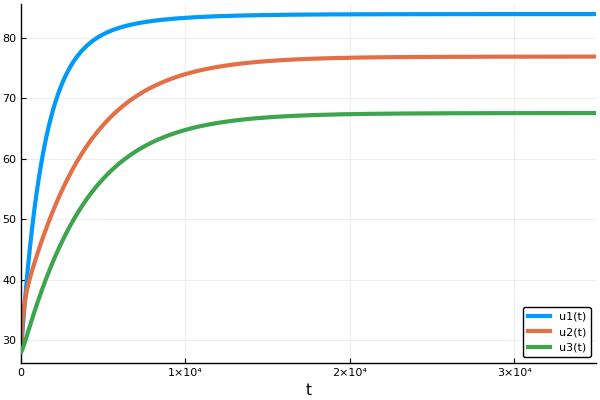

In [6]:
plot(sol)

In [147]:
# findind steady state solution
prob_steady_state = ODEProblem(gen,x0,(0.,50000),u)
sol_steady_state = solve(prob_steady_state,DynamicSS(Tsit5()));

In [148]:
using ForwardDiff
# steady state state values
xs = sol_steady_state.u[end,1]

3-element Array{Float64,1}:
 80.78833139099936
 74.75986840519487
 65.42274855797933

In [149]:
us = u


7-element Array{Float64,1}:
    3.8
 1055.0
 5360.0
  212.0
  528.0
   53.9
   49.2

In [151]:
using DiffEqDiffTools
using ForwardDiff
# functions in states and inputs
fx(x) = gen(x,us,0)
fu(u) = gen(xs,u,0)
# Jacobians at operating points
A = ForwardDiff.jacobian(fx,xs)
#B = ForwardDiff.jacobian(test_fu,us)

TypeError: TypeError: in setindex!, in typeassert, expected Float64, got ForwardDiff.Dual{Nothing,Float64,3}

ArgumentError: ArgumentError: Package DiffEqDiffTools not found in current path:
- Run `import Pkg; Pkg.add("DiffEqDiffTools")` to install the DiffEqDiffTools package.


In [140]:
using ForwardDiff
# functions in states and inputs
fx(x) = Model1ODE(x,us,0)
fu(u) = Model1ODE(xs,u,0)
# Jacobians at operating points
A = ForwardDiff.jacobian(fx,xs)
B = ForwardDiff.jacobian(fu,us)
# Calculating time constants
# Eigen value of system matrix, A
using LinearAlgebra
# Eigenvector
R = eigvecs(A)
# Eigenvalues
λ = eigvals(A)
# Time Constants
τ = - @. inv(λ)/60

TypeError: TypeError: in setindex!, in typeassert, expected Float64, got ForwardDiff.Dual{Nothing,Float64,3}